In [2]:
from langchain_ollama import ChatOllama

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import os
from langchain_core.messages import SystemMessage
from pydantic import BaseModel
from typing import List

In [3]:
load_dotenv()
tavily_api_key = os.getenv("tavily_api_key")


parameters = {
    "frequency_penalty": 0,
    "max_tokens": 3000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

llm = ChatOllama(
    model="granite3.2:8b-instruct-fp16",
    frequency_penalty= 0,
    max_tokens= 1000,
    presence_penalty= 0,
    temperature= 0,
    top_p= 1
)



llm.invoke("what is the capital of Iran")

AIMessage(content="The capital of Iran is Tehran. It's the largest city in the country and serves as its political, cultural, commercial, and industrial center.", additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-12T00:21:08.835955Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6978988700, 'load_duration': 3765192300, 'prompt_eval_count': 50, 'prompt_eval_duration': 369000000, 'eval_count': 36, 'eval_duration': 2843000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-52900f72-3df0-4dcf-96ee-7653f2cf5a1a-0', usage_metadata={'input_tokens': 50, 'output_tokens': 36, 'total_tokens': 86})

from langchain_ibm import ChatWatsonx
url = os.getenv("URL")
apikey = os.getenv("APIKEY")
project_id = os.getenv("project_id")
#model_id = "meta-llama/llama-3-3-70b-instruct"
#model_id = "ibm/granite-3-8b-instruct"
def create_chat_model(model_id):
    return ChatWatsonx(
    model_id=model_id,
    url=url,
    apikey=apikey,
    project_id=project_id,
    params=parameters,
)
llm = create_chat_model(model_id)

In [5]:
from pydantic import BaseModel, Field

In [6]:
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question")
    followup_question: str = Field(description="A followup question the user could ask")

model_with_tools = llm.bind_tools([ResponseFormatter])
# Invoke the model
ai_msg = model_with_tools.invoke("what is the capital of Iran? ")
ai_msg.tool_calls[0]

IndexError: list index out of range

In [7]:
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

In [8]:
output.search_query, output.justification

('Calcium CT score high cholesterol',
 'To understand the relationship between Calcium CT score and high cholesterol.')

# prompt chain

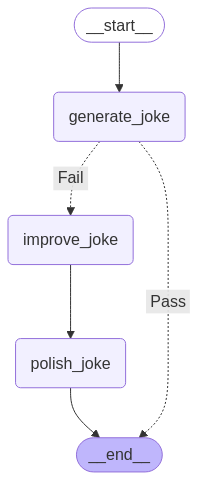

In [9]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()
chain

In [13]:
state = chain.invoke({"topic": "gold"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why don't gold medalists ever get lost? Because they always follow the "Golden Path"!

--- --- ---

Improved joke:
Why don't gold medalists ever lose their way in a maze of mirrors? Because they're always on the "Reflective Route", shining bright like the prize they've won!

--- --- ---

Final joke:
Why don't gold medalists ever lose their way in a maze of mirrors? Because they're always on the "Reflective Route," shining so bright that even the mirrors can't handle the glare and start reflecting them back to the exit, leading them straight out!


# parallel prompts

In [15]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Invoke
state = parallel_workflow.invoke({"topic": "bare butt spanking"})
print(state["combined_output"])


Here's a story, joke, and poem about bare butt spanking!

STORY:
Title: "The Unconventional Lesson"

Once upon a time in the small town of Bumblebee, there lived a mischievous young boy named Timmy. Known for his pranks and tricks, Timmy was a handful for his parents, especially his stern father, Mr. Thompson.

One sunny afternoon, Timmy decided to play a prank on the town's grumpy old baker, Mr. Crumbles. He snuck into the bakery and replaced all the jam with mustard. When the townsfolk tasted their pastries, chaos ensued, and laughter echoed through the streets.

Mr. Thompson, who had been in the bakery earlier, was not amused when he returned home to find his son giggling over the havoc caused. He decided it was time for Timmy to learn a lesson about responsibility and respect.

The next day, Mr. Thompson called Timmy into the living room. On the table was an old wooden chair and a soft feather duster. Timmy's eyes widened as he realized what was about to happen - a bare bottom span

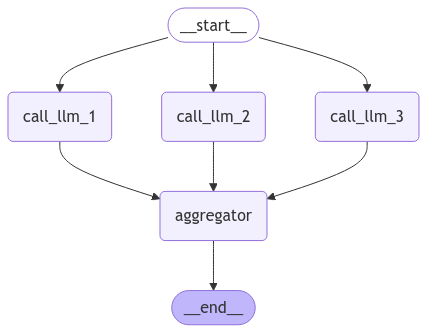

In [16]:

# Show workflow
display(parallel_workflow)

# routing

In [19]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()



# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Why don't cats play poker in the jungle? 

Too many cheetahs!


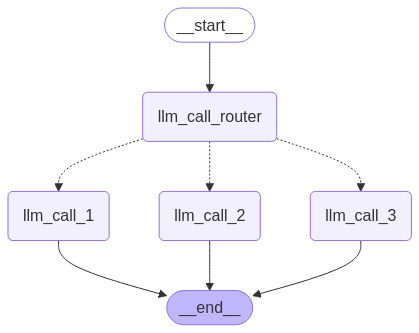

In [20]:
# Show the workflow
display(router_workflow)

# agent

In [21]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

#By default, the return value routing_function is used as the name of the node (or list of nodes) to send the state to next. 
#All those nodes will be run in parallel as a part of the next superstep.
#You can optionally provide a dictionary that maps the routing_function's output to the name of the next node

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

7


In [28]:
state

{'messages': [SystemMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'granite3.2:8b-instruct-fp16', 'created_at': '2025-03-12T01:24:22.6402525Z', 'done': True, 'done_reason': 'stop', 'total_duration': 469928000, 'load_duration': 24533800, 'prompt_eval_count': 242, 'prompt_eval_duration': 443000000, 'eval_count': 1, 'eval_duration': None, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-bbf13c12-8e03-4708-89a3-fa2cc3b18f28-0', usage_metadata={'input_tokens': 242, 'output_tokens': 1, 'total_tokens': 243})]}

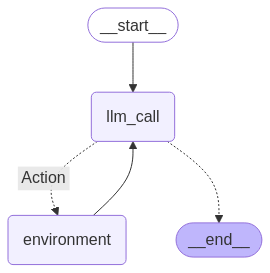

In [25]:
agent

In [29]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatOllama(model='granite3.2:8b-instruct-fp16', temperature=0.0, top_p=1.0), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [30]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.runnables.base import RunnableBinding

# Define the initial state
class ChatState(TypedDict):
    messages: List[BaseMessage]

# Nodes
def start_conversation(state: ChatState):
    """Start the conversation with a greeting"""
    return {
        "messages": [
            SystemMessage(content="Hello! How can I assist you today?")
        ]
    }

def respond_to_user(state: ChatState):
    """Respond to the user's message"""
    response = llm_with_tools.invoke(state["messages"])
    return {
        "messages": state["messages"] + [response]
    }

# Build workflow
chatbot_builder = StateGraph(ChatState)

# Add nodes
chatbot_builder.add_node("start_conversation", start_conversation)
chatbot_builder.add_node("respond_to_user", respond_to_user)

# Add edges to connect nodes
chatbot_builder.add_edge(START, "start_conversation")
chatbot_builder.add_edge("start_conversation", "respond_to_user")
chatbot_builder.add_edge("respond_to_user", END)

# Compile the chatbot
chatbot = chatbot_builder.compile()

# Invoke the chatbot
initial_state = {"messages": []}
state = chatbot.invoke(initial_state)
for message in state["messages"]:
    message.pretty_print()

================================ System Message ================================

Hello! How can I assist you today?
================================== Ai Message ==================================


In [40]:

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "What is the total sum of the numbers 11, 13, and 20?")]}
print_stream(chatbot.stream(inputs, stream_mode="values"))

('user', 'What is the total sum of the numbers 11, 13, and 20?')
================================ System Message ================================

Hello! How can I assist you today?
================================== Ai Message ==================================
